# QPCA-assisted Variational Quantum Classifier (VQC) for MNIST Classification

The aim of this project is to explore the VQC algorithm available in Qiskit for classifying MNIST dataset. The MNIST dataset will be dimensionally reduced by utilizing classical Principal Component Analysis (PCA) and the quantum version of PCA (QPCA) to n principal components (basically reducing the data features from 28x28 to n for every image).

We will try to classify only number 3 and 6 from MNIST dataset to simplify the problem.

## Importing the Package

In [1]:
!pip install qiskit
!pip install renom_q
from IPython.display import clear_output
clear_output()

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf

In [3]:
from renom_q import *
from renom_q.ml.qpca import QPCA

In [4]:
from qiskit.ml.datasets import ad_hoc_data, breast_cancer
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import SPSA, COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.aqua.components.feature_maps import RawFeatureVector, SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name, get_feature_dimension

## Load the MNIST Dataset

MNIST dataset consists of thousand images of hand-written digits from 0 to 9. Every image has 28x28 pixels and every pixel's value is between 0 to 255. This dataset is too large for us. So we need to reduce it.

1). Normalizing the pixel's value in the range of [0,1].

2). Filtering images from the dataset, leaving only the images with number 3 and 6 as their labels.

3). Reducing the total number of images in the dataset and divide the dataset into training dataset and testing dataset.

4). Resize the image from 28x28 pixels to 16x16 pixels because QPCA needs the size of the image in the form of 2^n x 2^n pixels.

In [44]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [45]:
# function to filter the image, leaving only the selected numbers
def filter_image(x, y):
    keep = (y == number_set[0]) | (y == number_set[1])
    x, y = x[keep], y[keep]
    y = y == number_set[0]
    return x,y

In [46]:
# choose the number to be classified here, in this case I selected number 3 and 6
number_set = [3, 6]

# filter the dataset
x_train, y_train = filter_image(x_train, y_train)
x_test, y_test = filter_image(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


In [47]:
# next, reduce the number of images inside the dataset

index_train = np.array([], dtype=int)
index_test = np.array([], dtype=int)

# decide how many images we want inside the dataset
num_data = 100
# decide what is the percentage of the dataset we want for the training dataset
train_percentage = 0.8

# train data
counter = np.array([0,0], dtype=int)
for i in range (len(x_train)):
    if y_train[i] == True and counter[0] < int(train_percentage*num_data/2):
        index_train = np.append(index_train, np.array([int(i)]), axis=0)
        counter[0] += 1

    if y_train[i] == False and counter[1] < int(train_percentage*num_data/2):
        index_train = np.append(index_train, np.array([int(i)]), axis=0)
        counter[1] += 1

# test data
counter = np.array([0,0], dtype=int)
for i in range (len(x_test)):
    if y_test[i] == True and counter[0] < int(np.round(1-train_percentage, 2)*num_data/2):
        index_test = np.append(index_test, np.array([int(i)]), axis=0)
        counter[0] += 1

    if y_test[i] == False and counter[1] < int(np.round(1-train_percentage, 2)*num_data/2):
        index_test = np.append(index_test, np.array([int(i)]), axis=0)
        counter[1] += 1

x_train = x_train[index_train]
y_train = y_train[index_train]
x_test = x_test[index_test]
y_test = y_test[index_test]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(80, 28, 28, 1) (80,)
(20, 28, 28, 1) (20,)


True


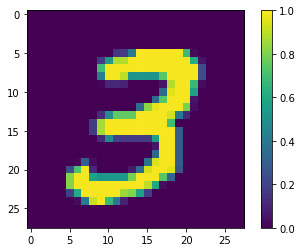

In [48]:
# plot an example of 1 image

print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [49]:
# resize the images

x_train_small = tf.image.resize(x_train, (16,16)).numpy()
x_test_small = tf.image.resize(x_test, (16,16)).numpy()

True


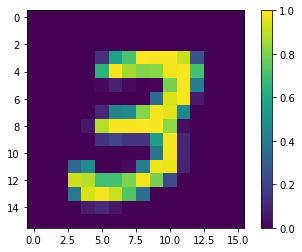

In [50]:
# plot an example of 1 resized image

print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

## Quantum Principal Component Analysis

The QPCA algorithm used here is the one developed by ReNomQ (https://www.renom.jp/packages/renomq/rsts/example/Quantum_machine_learning/notebook/03.Quantum-PCA.html), based on research paper "Total Quantum Search of Optimal Solution in Quantum Computing" (https://confit.atlas.jp/guide/event/jsai2019/subject/2E1-J-1-02/advanced).

We will try to see the effect of applying QPCA to the image for 1 example, and then apply QPCA to all images inside the dataset.

In [ ]:
# select an image from the dataset
mnist_image = x_train_small[0,:,:,0]

# 2 principal component so we can run the VQC later by just using 2 qubits
n_components_quantum = 2
qpca = QPCA(n_components=n_components_quantum)
qpca.fit(mnist_image, method='QPSO', n_particle=80, steps=20)

In [ ]:
# print the eigenvalues and the eigenvectors
# the one we will use for the training is the principal components (eigenvalues)

print(qpca.eigenvalue)
print()
print(qpca.components_)

[0.428879511509665, 0.42549741490019727]

[[-9.01490521e-02 -1.17904980e-01 -9.43606703e-02 -1.23413311e-01
  -4.00118865e-01 -5.23311181e-01 -4.18811772e-01 -5.47759434e-01
  -3.11686306e-02 -7.28487155e-03 -3.26247787e-02 -7.62520899e-03
  -1.38339304e-01 -3.23332799e-02 -1.44802293e-01 -3.38438385e-02]
 [-5.47557192e-02  1.26199912e-01 -5.27362429e-02  1.21545462e-01
   2.37197866e-04 -5.46689005e-04  2.28449638e-04 -5.26526262e-04
  -3.49146175e-01 -6.14770859e-01 -3.36269120e-01 -5.92097151e-01
   1.51247630e-03  2.66314346e-03  1.45669381e-03  2.56492257e-03]]


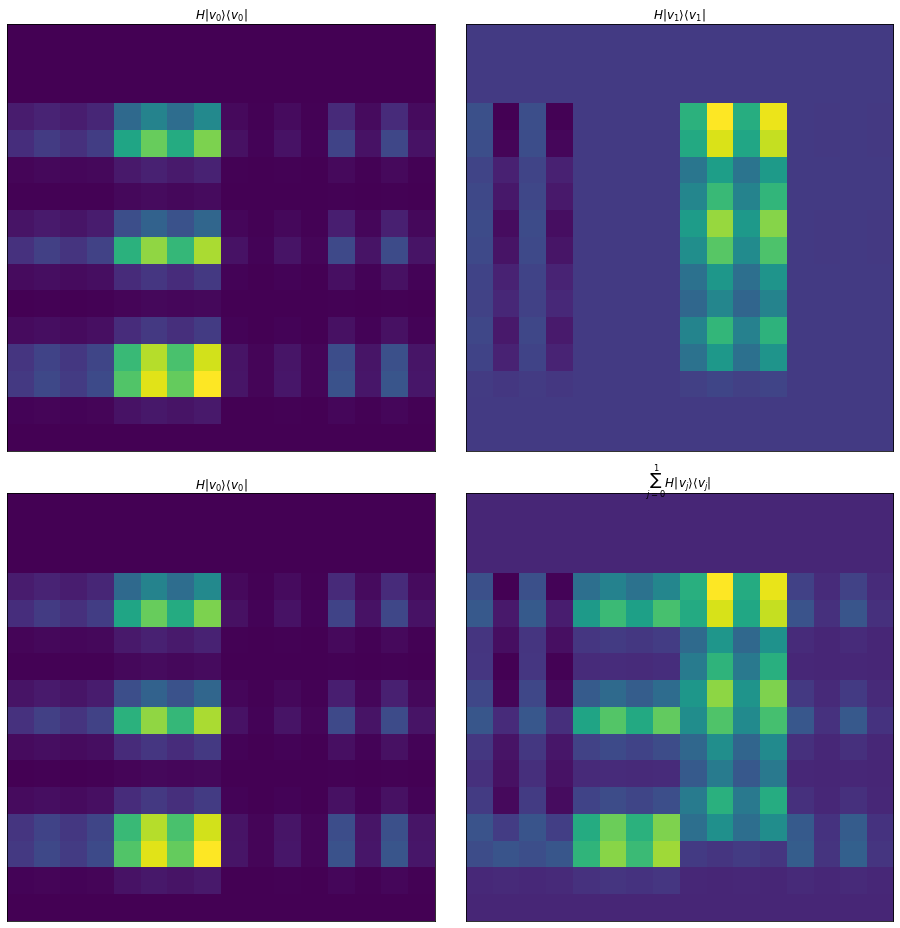

In [ ]:
# plot the image after QPCA

num = n_components_quantum

size = int(np.log2(mnist_image.shape[0]))
eigenvector_image = []
eigenvector_sum_image = [np.zeros((2**size, 2**size)) for i in range(num)]

for i in range(num):
    vec = np.outer(qpca.components_[i], qpca.components_[i])
    array = np.dot(mnist_image, vec)
    eigenvector_image.append(array)
    for j in range(num-i):
        eigenvector_sum_image[num-1-j] += array

rc('text', usetex=False)
title = []
for i in range(num):
    title.append(r'$H \left| v_'+str(i)+r' \right\rangle \left\langle v_'+str(i)+r' \right|$')
title.append(r'$H \left| v_0 \right\rangle \left\langle v_0 \right|$')
for i in range(num-1):
    title.append(r'$\sum^'+str(i+1)+r'_{j=0} H \left| v_j \right\rangle \left\langle v_j \right|$')

fig = plt.figure(figsize=(13,13))

for i in range(2*num):
    plt.subplot(2, num, i+1)
    if i < num:
        plt.imshow(eigenvector_image[i])
    else:
        plt.imshow(eigenvector_sum_image[i-num])
    plt.title(title[i])
    plt.tick_params(bottom=False, left=False)
    plt.tick_params(labelbottom=False, labelleft=False)

fig.tight_layout()
plt.show()

In [51]:
# apply QPCA to every images in the dataset
# the dataset will now contains the eigenvalues from every images

# decide the number of principal components to be used
n_components_quantum = 8

x_train_small_qpca = np.zeros((len(x_train_small), n_components_quantum))
x_test_small_qpca = np.zeros((len(x_test_small), n_components_quantum))

print(x_train_small_qpca.shape, x_test_small_qpca.shape)

for i in range (len(x_train_small_qpca)):
    qpca = QPCA(n_components=n_components_quantum)
    qpca.fit(x_train_small[i,:,:,0], method='QPSO', n_particle=80, steps=20)
    x_train_small_qpca[i,:] = np.array(qpca.eigenvalue)

for i in range (len(x_test_small_qpca)):
    qpca = QPCA(n_components=n_components_quantum)
    qpca.fit(x_test_small[i,:,:,0], method='QPSO', n_particle=80, steps=20)
    x_test_small_qpca[i,:] = np.array(qpca.eigenvalue)

(80, 8) (20, 8)


In [52]:
# as this process takes quite sometime, it's better to save the results so we
# do not need to repeat this step again every time we reboot this notebook

# change the directory according to your Google Drive folder directory (if using
# Colab) or your PC directory
dir = '/content/drive/My Drive/Projects/quantum_image_classifier/Qiskit/'
np.savetxt(dir+'x_train_small_qpca_100_8.txt', x_train_small_qpca)
np.savetxt(dir+'x_test_small_qpca_100_8.txt', x_test_small_qpca)

In [ ]:
# this one is to load the dataset if we reboot and don't want to redo the QPCA

x_train_small_qpca = np.loadtxt(dir+'x_train_small_qpca_400.txt')
x_test_small_qpca = np.loadtxt(dir+'x_test_small_qpca_400.txt')

In [53]:
# sanity check

print(x_train_small_qpca.shape, x_test_small_qpca.shape)
print(y_train.shape, y_test.shape)

(80, 8) (20, 8)
(80,) (20,)


## Classical Principal Component Analysis

We will use the well-known scikit-learn package for the classical PCA (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [39]:
# decide the number of principal components to be used
n_components_classic = 8

pca = PCA(n_components=n_components_classic, whiten = False, random_state = 2020)

# the classical PCA is quite fast so I don't think we need to save the result

In [40]:
x_train_small_pca = pca.fit_transform(x_train_small.reshape(len(x_train_small),16**2))
x_test_small_pca = pca.fit_transform(x_test_small.reshape(len(x_test_small),16**2))
x_train_small_pca.shape, x_test_small_pca.shape

((80, 8), (20, 8))

In [31]:
# only run this one if we need to normalize the PCA output
# some VQC configurations need this

def normalize(x):
  return (x - x.min())/(x.max() - x.min())

x_train_small_pca = normalize(x_train_small_pca)
x_test_small_pca = normalize(x_test_small_pca)

## Dataset Reformatting

VQC class from Qiskit need a specific format for the dataset. This section is dedicated to do that. You can read the documentation here (https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.VQC.html).

In [54]:
def dataset_format(x, y, bool_value):
    keep = (y == bool_value)
    a = x[keep]
    return a

In [55]:
# QPCA dataset reformatting

# for number 3
A_train = dataset_format(x_train_small_qpca, y_train, True)
A_test = dataset_format(x_test_small_qpca, y_test, True)

# for number 6
B_train = dataset_format(x_train_small_qpca, y_train, False)
B_test = dataset_format(x_test_small_qpca, y_test, False)

print(A_train.shape, B_train.shape)
print(A_test.shape, B_test.shape)

train_dict_qpca = {'A': A_train, 'B': B_train}
test_dict_qpca = {'A': A_test, 'B': B_test}

(40, 8) (40, 8)
(10, 8) (10, 8)


In [41]:
# Classical PCA dataset reformatting

# for number 3
A_train = dataset_format(x_train_small_pca, y_train, True)
A_test = dataset_format(x_test_small_pca, y_test, True)

# for number 6
B_train = dataset_format(x_train_small_pca, y_train, False)
B_test = dataset_format(x_test_small_pca, y_test, False)

print(A_train.shape, B_train.shape)
print(A_test.shape, B_test.shape)

train_dict_pca = {'A': A_train, 'B': B_train}
test_dict_pca = {'A': A_test, 'B': B_test}

(40, 8) (40, 8)
(10, 8) (10, 8)


## Variational Quantum Classifier

This is the final section and finally we can play with the VQC.

We need to tune the VQC by trying different parameters until we get good results. The best parameters for VQC that is trained with QPCA dataset maybe (and by 'maybe' I mean high chance) different with the one that is trained with classical PCA. There are many good tutorials on VQC here https://github.com/qiskit-community/qiskit-community-tutorials/tree/master/machine_learning .

In [56]:
# a function to store the intermediate data during the optimization

def store_intermediate_result(eval_count, parameters, mean, indx):
            counts.append(eval_count)
            values.append(mean)
            params.append(parameters)
            batch_index.append(indx)

### QPCA-assisted VQC

In [57]:
# tune the VQC parameters

counts = []
values = []
batch_index = []
params = []

#random_seed = 10598
shots = 1024

backend = BasicAer.get_backend('qasm_simulator')
optimizer = SPSA(maxiter=100)
#optimizer.set_options(save_steps=1)
#feature_map = ZZFeatureMap(feature_dimension=n_components_quantum, reps=2)
#var_form = TwoLocal(n_components_quantum, ['ry', 'rz'], 'cz', reps=3)
feature_map = RawFeatureVector(feature_dimension=get_feature_dimension(train_dict_qpca))
var_form = TwoLocal(feature_map.num_qubits, ['ry', 'rz'], 'cz', reps=3)
vqc = VQC(optimizer, feature_map, var_form, train_dict_qpca, test_dict_qpca, callback=store_intermediate_result)
quantum_instance = QuantumInstance(backend, shots=shots)

testing success ratio:  0.65


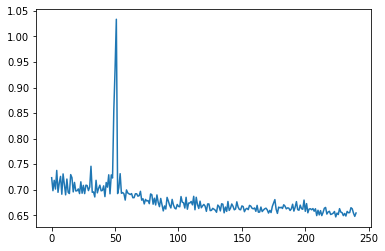

In [58]:
# principal components = 8

result = vqc.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

# plot the evaluated values for each iteration
plt.plot(counts, values)

### Classical PCA-assisted VQC

In [42]:
# tune the VQC parameters

counts = []
values = []
batch_index = []
params = []

#random_seed = 10598
shots = 1024

backend = BasicAer.get_backend('qasm_simulator')
optimizer = SPSA(maxiter=100)
#optimizer.set_options(save_steps=1)
feature_map = ZZFeatureMap(feature_dimension=n_components_classic, reps=2)
var_form = TwoLocal(n_components_classic, ['ry', 'rz'], 'cz', reps=3)
#feature_map = RawFeatureVector(feature_dimension=get_feature_dimension(train_dict_pca))
#feature_map = SecondOrderExpansion(feature_dimension=get_feature_dimension(train_dict_pca), depth=2)
#var_form = TwoLocal(feature_map.num_qubits, ['ry', 'rz'], 'cz', reps=3)
vqc = VQC(optimizer, feature_map, var_form, train_dict_pca, test_dict_pca, callback=store_intermediate_result)
quantum_instance = QuantumInstance(backend, shots=shots)

testing success ratio:  0.65


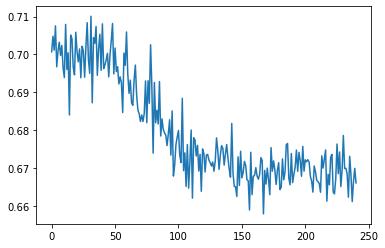

In [43]:
# principal components = 8

result = vqc.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

# plot the evaluated values for each iteration
plt.plot(counts, values)

Clearly we can see that the training is not yet optimal as the testing success ratio is still low (classical machine learning can reach >95% testing accuracy easily).

Besides tuning the VQC parameter, we can also tune the number of principal components we want from QPCA and classical PCA. I tried using the same configuration of VQC but changing the principal components from 8 to 6 and I got 0.6 testing success ratio. So the number of principal components is also an important parameter to be considered.